#### This notebook solely for evaluation purpose only, The data set that I had used is Twitter US Airline Sentiment. Details about the versions of libraries used for this project you can find it in "Readme.txt". 
    
    
## Structure:
   
    Application
        a. Dataset discription
        b. Problem Description
        c. Exploratory Analysis
        d. Feature Selection
        e. Data Preprocessing
            i. Creating data bunches
            ii. Tokenisation
            iii. Numericalization
        f. Modelling
            i. Pre-trained Learning
            ii. Learning rate selection
            iii. Fine-tuning
            iv. Transfer Learning Classifier Model
            v. Learning rate selection
            vi.  Fine-tuning
            vii. Prediction and Results
    Conclusion
    Reference



## Application

### a. Dataset Discription

This data originally came from Crowdflower's Data for Everyone library.
(http://www.crowdflower.com/data-for-everyone)

As the original source says,

    A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

### b. Problem Discription

The data set that we are working with consist of various features, and we are asked to make a NLP model to get the maximum accuracy for sentiment analysis of the text data available to us. In addition to that we need to use Universal Language Model Fine-tuning for Text Classification(ULMFiT) an effective transfer
learning method that can be applied to any task in NLP, and introduce techniques that are key for fine-tuning a language model.

### c. Exploratory Analysis

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph.

import tensorflow as tf

# Modeling, selection, and evaluation
from fastai.text import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels

%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud


max_ =100

In [3]:
#Loading CSV file
pd.set_option('display.max_colwidth', -1)

df = pd.read_csv("Tweets.csv")
df_ = pd.read_csv("Tweets.csv") # For evaluation without doing preprocessing

    For the following steps, in order to process the data in the machine learning algorithms, we need to first convert it from text to numbers, as from what I understand, most algorithms run better that way. From most of the books I've read, data cleaning/preprocessing is *THE* most important part of any machine learning process, as high quality data translates to high quality predictions and models.

In [4]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
columns = ['tweet id','airline sentiment','airline sentiment confidence','negative reason',
           'negative reason confidence','airline','airline sentiment gold','name','negative gold',
           'retweet count','text','tweet coord','tweet created','tweet location','user timezone']

In the dataset we can find so much NaN, We will remove any attribute with more than 67% of NaN.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

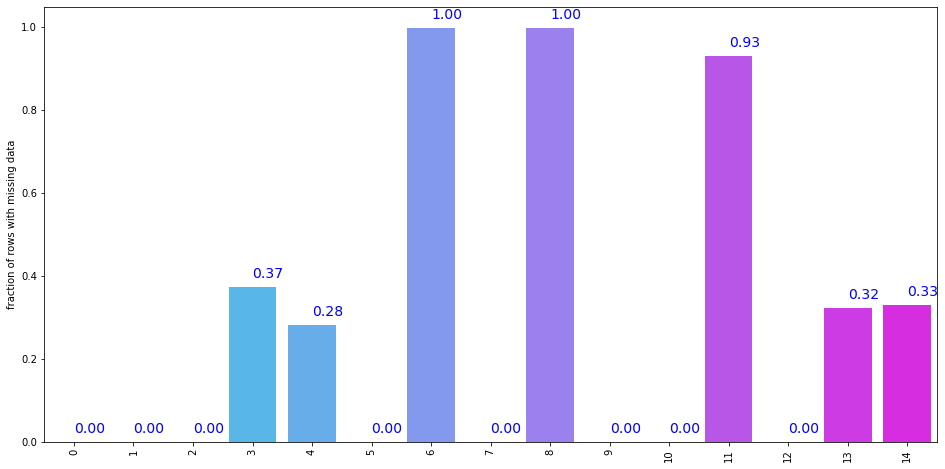

0   tweet id
1   airline sentiment
2   airline sentiment confidence
3   negative reason
4   negative reason confidence
5   airline
6   airline sentiment gold
7   name
8   negative gold
9   retweet count
10   text
11   tweet coord
12   tweet created
13   tweet location
14   user timezone


In [7]:
null_counts = df.isnull().sum()/len(df)
plt.figure(figsize=(16,8))
plt.xticks(np.arange(len(null_counts)),null_counts.index,rotation='vertical')
plt.ylabel('fraction of rows with missing data')
vis1= sns.barplot(np.arange(len(null_counts)),null_counts,palette='cool')


for p in vis1.patches:
             vis1.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_height()),
                 ha='left', va='top', fontsize=14, color='blue', xytext=(0, 20),
                 textcoords='offset points')
        #This annotation provides the fraction of missing data.
        
plt.show()

for i in range(len(columns)):
    print(i," ",columns[i])

"airline sentiment gold", "negative gold" and "tweet coord" are the attribute with more than 67% of NaN values. 

Let's check the distribution of NaN values in the dataset.

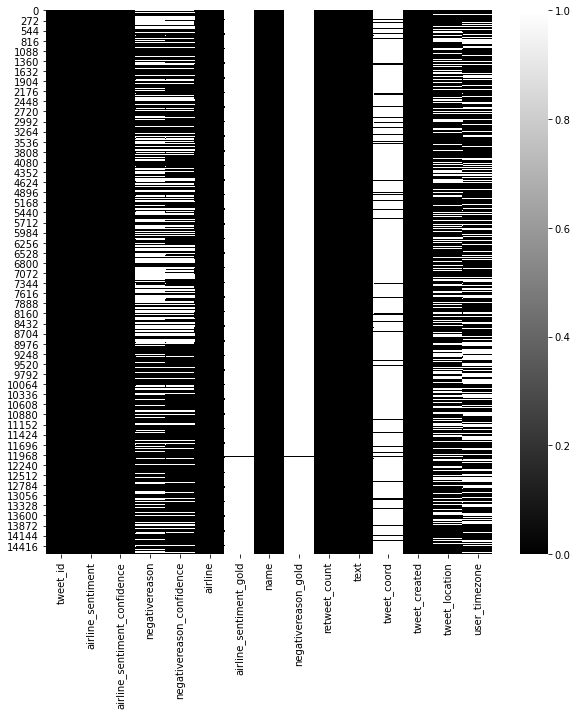

In [8]:
plt.figure(figsize=(10,10))

sns.heatmap(df.isnull(),cmap='binary_r')

 As the distribution is *uniform* we remove these attributes.

In [9]:
df.drop(["airline_sentiment_gold","negativereason_gold","tweet_coord"],inplace=True,axis=1)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   name                          14640 non-null  object 
 7   retweet_count                 14640 non-null  int64  
 8   text                          14640 non-null  object 
 9   tweet_created                 14640 non-null  object 
 10  tweet_location                9907 non-null   object 
 11  user_timezone                 9820 non-null   object 
dtypes: float64(2), int64(2), object(8)
memory usage: 1.3+ MB


In [11]:
df["airline"].unique()

array(['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways', 'American'], dtype=object)

There are six unique filghts. Let's look at text's length distribution of various flights.

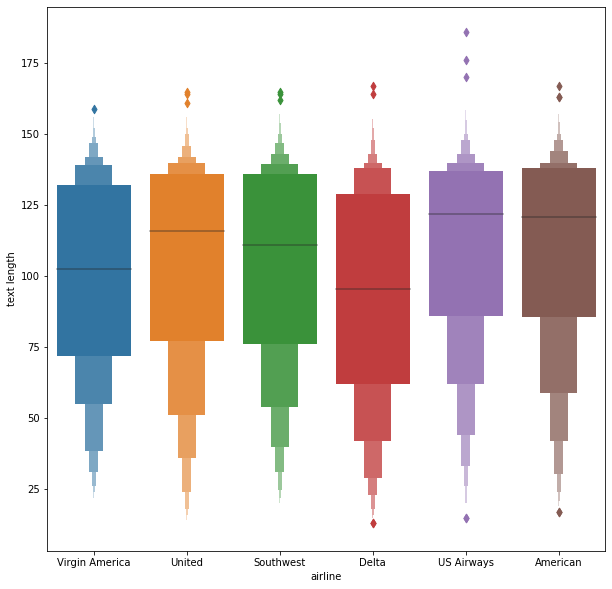

In [12]:
df['text']=df['text'].astype(str)
df['text length']=df['text'].apply(len)

plt.figure(figsize=(10,10))
vis1=sns.boxenplot(x='airline', y='text length', data=df)


Virgin America , 125.0
United , 124.0
Southwest , 126.0
Delta , 119.0
US Airways , 126.0
American , 129.0


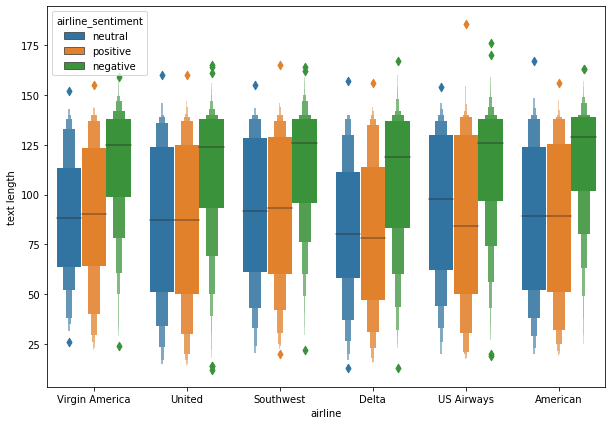

In [13]:
plt.figure(figsize=(10,7))

vis2=sns.boxenplot(x='airline', y='text length', data=df,hue='airline_sentiment')

for i in df['airline'].unique():
    print(i,",",df[(df['airline']==i) & (df['airline_sentiment']=='negative')]['text length'].median())

Plot vis2 clearly shows median value of "Text Length" is nearly same for all the airlines. Further we try to see the word distribution in airline sentiment.

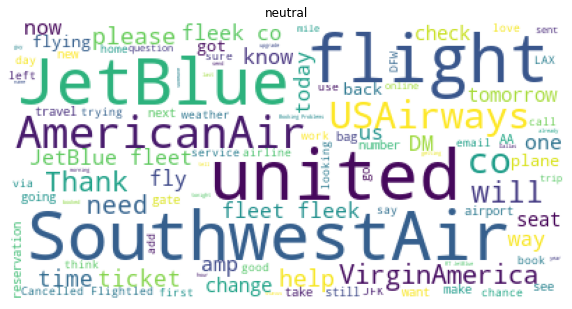

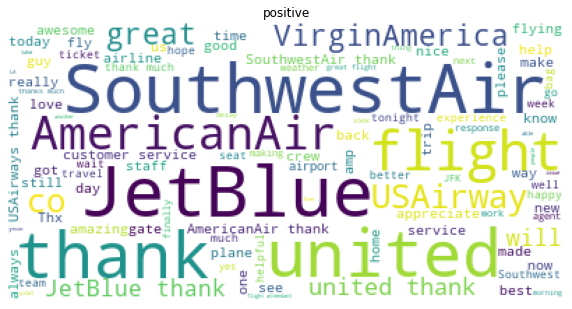

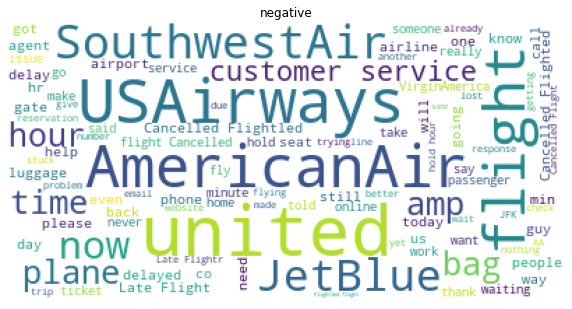

In [14]:
for i in df['airline_sentiment'].unique():
    list_=df[df['airline_sentiment']==i]['text'].tolist()
    plt.figure(figsize = (10,12))
    plt.title(i)
    wc = WordCloud(background_color = "white", max_words = 100,  max_font_size = 50)
    wc.generate(' '.join(list_))
    plt.imshow(wc)
    plt.axis('off')

#### Most of the values of airline_sentiment contains the name of the Airline services that person used, this may be due to all the text contains tags that has structure @___FlightName___ .

     Now let's look on the number of unique sentiments that we can find in airline_sentiment attribute.

neutral 3099
positive 2363
negative 9178


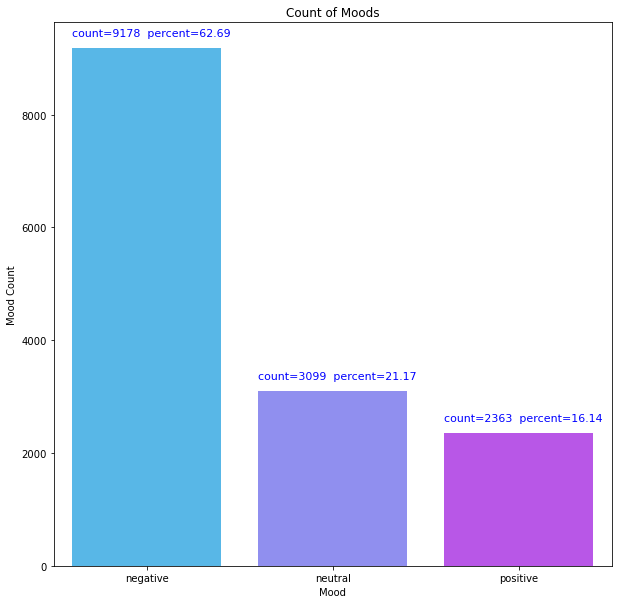

In [15]:
Index = [1,2,3]

plt.figure(figsize=(10,10))
total = 14640

vis1= sns.barplot(x=['negative','neutral','positive'],y=df['airline_sentiment'].value_counts(),palette='cool')

for i in df['airline_sentiment'].unique():
    print(i,len(df[df['airline_sentiment']==i]))

plt.ylabel('Mood Count')
plt.xlabel('Mood')
plt.title('Count of Moods')

for p in vis1.patches:
    tag = (p.get_height()/total)*100
    vis1.annotate("count={count:04d}  percent={tag:04.2f}".format(count= int(p.get_height()),tag=tag) 
                  , (p.get_x(), p.get_height()),
                 ha='left', va='top', fontsize=11, color='blue', xytext=(0, 20),
                 textcoords='offset points')

By analyzing above plot we can say that our dataset is biased towards negative values as it contributes around 62.29%.

## Data Cleaning 
    Process involves
* Conversion of all string into lower case.
* Removing stopwords i.e. nltk_words+stop_words
* Removing any word with 2 or less than two letters 
* Removing numbers.

In [16]:
#data cleaning

from collections import Counter
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words

import nltk

from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS

from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer

import re

porter = PorterStemmer()
lancaster=LancasterStemmer()

a = df['text'].str.lower().str.cat(sep=' ')

# removes punctuation,numbers -> list of words
b = re.sub('[^A-Za-z]+', ' ', a)

#remove all the stopwords from the text
stop_words = list(get_stop_words('en'))         
nltk_words = list(stopwords.words('english'))

stop_words.extend(nltk_words)

word_tokens = word_tokenize(b)

filtered_sentence = []
filtered_sentence = [w for w in word_tokens if not w in stop_words]

# #lemmatization and stemming
# filtered_sentence = [porter.stem(w) for w in word_tokens]
# filtered_sentence = [lancaster.stem(w) for w in word_tokens]

# remove words with length less than 2
without_single_chr = [word for word in filtered_sentence if len(word) > 2]

# remove numbers
cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]        

word_dist = nltk.FreqDist(cleaned_data_title)
rslt = pd.DataFrame(word_dist.most_common(max_),
                    columns=['Word', 'Frequency'])

    Visualizing the text attribute that is left after set of data cleaning.

(-0.5, 399.5, 199.5, -0.5)

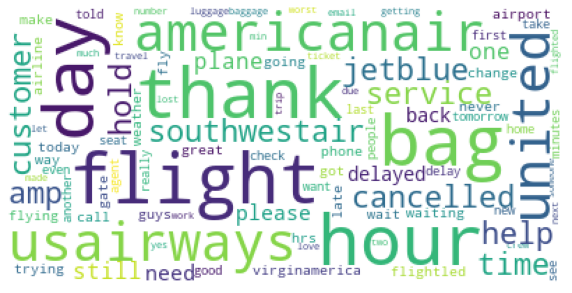

In [17]:
rslt=rslt["Word"].values.tolist()

plt.figure(figsize = (10,12))
wc = WordCloud(background_color = "white", max_words = 1000,  max_font_size = 50)
wc.generate(' '.join(rslt))
plt.imshow(wc)
plt.axis('off')

In [18]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone,text length
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),35
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials to the experience... tacky.,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),72
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),71
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),126
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing about it,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),55


Now let us visualize the word_cloud of the text w.r.t. sentiment type.

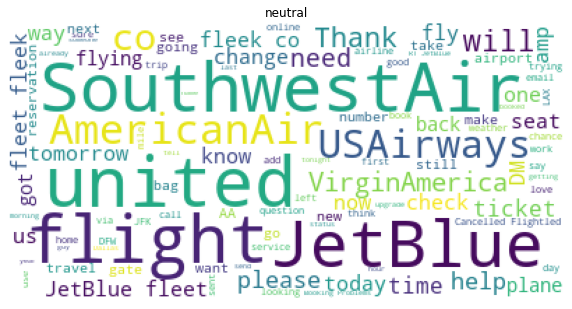

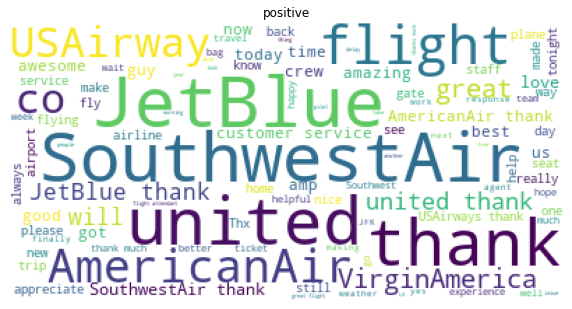

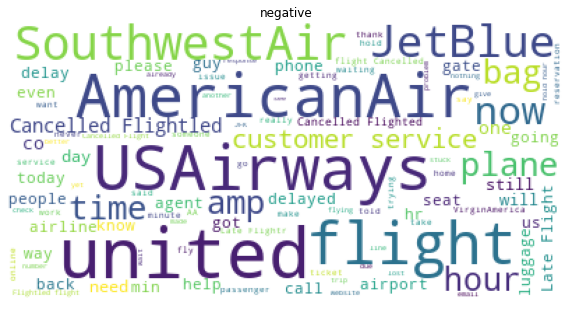

In [19]:
for i in df['airline_sentiment'].unique():
    list_=df[df['airline_sentiment']==i]['text'].tolist()
    plt.figure(figsize = (10,12))
    plt.title(i)
    wc = WordCloud(background_color = "white", max_words = 100,  max_font_size = 50)
    wc.generate(' '.join(list_))
    plt.imshow(wc)
    plt.axis('off')

Now Let's compare the number of review_text on the basis of the Airline services used by user.

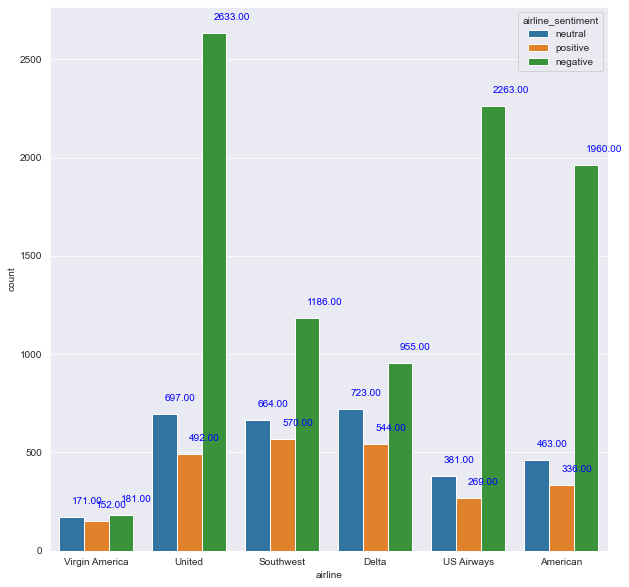

In [20]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,10))

vis = sns.countplot(data = df, x='airline',hue = 'airline_sentiment')

for p in vis.patches:
    vis.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_height()),
                 ha='left', va='top', fontsize=10, color='blue', xytext=(0, 20),
                 textcoords='offset points')

plt.ioff()

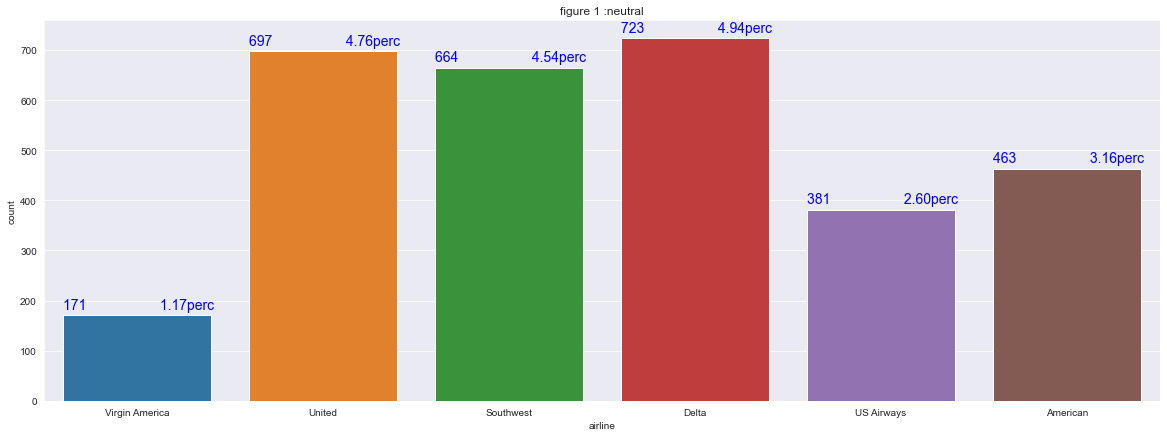

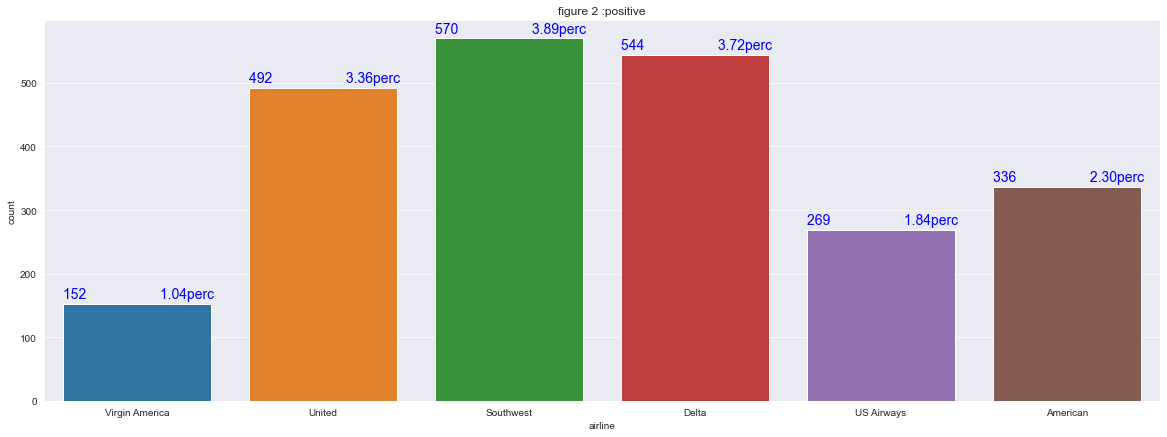

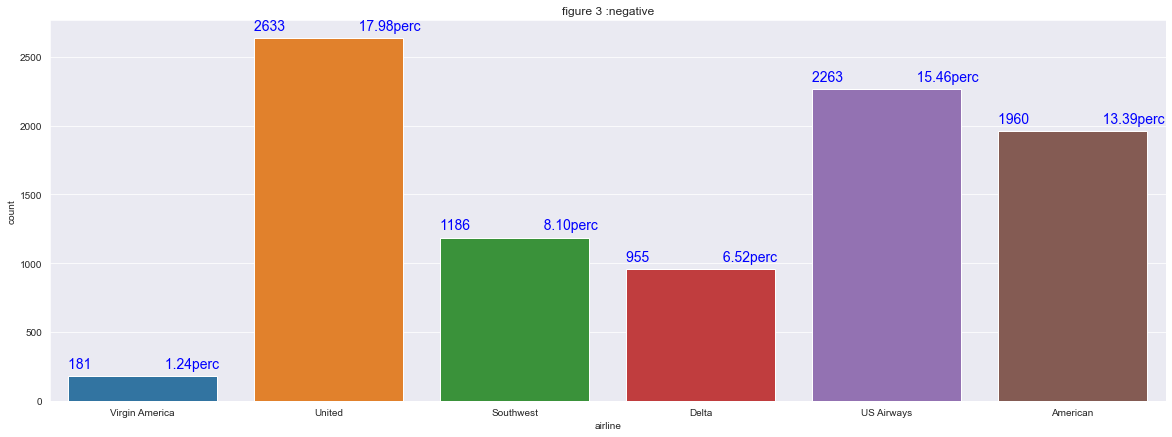

In [21]:
for c,i in enumerate(df['airline_sentiment'].unique()):
    plt.figure(figsize=(20,7))
    total = 14640 # from the previous analysis
    tag_ = 'figure '+str(c+1)+" :"+i
    plt.title(tag_)
    vis1 = sns.countplot(data = df[df['airline_sentiment']==i],x = 'airline')
    for p in vis1.patches:
        tag = (p.get_height()/total)*100
        vis1.annotate("{count:.0f}                   {tag:04.2f}perc".format(count= p.get_height(),tag=tag) 
                  , (p.get_x(), p.get_height()-5),
                 ha='left', va='top', fontsize=14, color='blue', xytext=(0, 20),
                 textcoords='offset points')
    plt.show()

#### Looking on the figure 3, we can say that people travelling through "United Airline" had given most of the negative reviews.

#### Now, we are done with the visualization segment lets apply the text_processing function to clean our data and replace it with our actual text attribute.
#### text_processing function consist of the following features:
* Conversion of all string into lower case.
* Removing stopwords i.e. nltk_words+stop_words
* Removing any word with 2 or less than two letters 
* Removing numbers.

In [22]:
import string

porter = PorterStemmer()
lancaster=LancasterStemmer()

def text_processing(cols):
    a = cols

    # removes punctuation,numbers -> list of words
    b = re.sub('[^A-Za-z]+', ' ', a)

    word_tokens = word_tokenize(b)

    filtered_sentence = []
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    
#     #lemmatization and stemming
#     filtered_sentence = [porter.stem(w) for w in word_tokens]
#     filtered_sentence = [lancaster.stem(w) for w in word_tokens]

    # remove words with length less than 2
    without_single_chr = [word for word in filtered_sentence if len(word) > 2]

    # remove numbers
    cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]
    
    a=' '.join(cleaned_data_title)
    
    return a

df['text'] = df['text'].apply(text_processing)

In [23]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone,text length
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,VirginAmerica What dhepburn said,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),35
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,VirginAmerica plus added commercials experience tacky,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),72
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,VirginAmerica today Must mean need take another trip,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),71
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,VirginAmerica really aggressive blast obnoxious entertainment guests faces amp little recourse,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),126
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,VirginAmerica really big bad thing,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),55


In [24]:
df.rename(columns={'airline_sentiment':'label'},inplace = True)

In [25]:
df = df[['label','text']]

In [26]:
df.head()

,label,text
0,neutral,VirginAmerica What dhepburn said
1,positive,VirginAmerica plus added commercials experience tacky
2,neutral,VirginAmerica today Must mean need take another trip
3,negative,VirginAmerica really aggressive blast obnoxious entertainment guests faces amp little recourse
4,negative,VirginAmerica really big bad thing


### d. Feature selection


Feature selection is the process of selecting what we think is worthwhile in our documents, and what can be ignored. Rejected features are those that act like noise, thus when fed to the model with the training set, the classification accuracy will decrease. In most NLP literature work, stop words, punctuations and non-formal vocabs are deprecated from the training set. 

   Furthermore, most work applies word stemming to return the used words to their lemma. We had applied same process to remove the noise. After completion of this model we will again create the model without removing any of the features. Besides, this notebook takes into consideration only the text field as the dependent variable where we leave the process of exploring the effectiveness of other features for future optimization.


In [27]:
test_percentage = 0.1
df_.sort_index(inplace=True)
cutoff = int(test_percentage * df.shape[0])
df_[['airline_sentiment', 'text']][:cutoff].to_csv('Tweets_filtered_test.csv', index=False, encoding='utf-8')
df_[['airline_sentiment', 'text']][cutoff:].to_csv('Tweets_filtered_train.csv', index=False, encoding='utf-8')
df_[['text']][cutoff:].to_csv('Tweets_text_only_train.csv', index=False, encoding='utf-8')

In [28]:
data = TextClasDataBunch.from_csv('.', 'Tweets_filtered_train.csv')
data.show_batch()

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup g. xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
"xxbos xxup @usairways xxup are xxup you xxup kidding xxup me ? ? xxmaj bad customer service , folks . xxmaj flew from xxup psp to xxup phx flight 2692 on 2 / 19 . ( cont ) http : / / t.co / xxunk",negative
xxbos @usairways xxup you xxup are xxup amazing ! ! ! xxup you xxup are xxup the xxup best ! ! ! xxup follow xxup me xxup please xxup and i xxup follow xxup you xxup xxunk 🙏 🙏 🙏 ✌ ️ 😉 ),positive
"xxbos @southwestair $ xxunk xxunk 4 / 30 - 5 / 5 "" xxup xxunk : xxup rt xxunk : xxmaj if you 're trying to make travel reservations for xxmaj vegas on xxmaj may 2nd it 's too xxmaj late xxmaj flight """,neutral
xxbos @jetblue xxmaj flight 136 departs xxunk xxup am xxmaj finally ! ! ! xxmaj arrived xxup jfk with no xxunk at xxunk xxup pm . xxmaj that 's a long flight . xxup aka xxup bus http : / / t.co / xxunk,negative


### e. Data Processing

###    i. Creating Data Bunches

In [29]:
bs = 24
seed = 331

### ii. Tokenization

We read in the data and add new words to our dictionary, as well as create a representation of words using numbers.

We have to use a special kind of TextDataBunch for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.


The following changes have been made to the text for ease of modeling:
- split on space and punctuation symbols
- the "'s" are grouped together in one token
- there are several special tokens (all those that begin by xx), to replace unknown tokens
- the contractions are separated like this: "did", "n't", "could", "n't"

In [74]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.']

Looking into the dataset we can now see the current representation post-processing, in both text form and numerical.

First we ingest the data once again but have a 10% holdout only since we'll be using it validation of the model.

In [75]:
data_lm = (TextList.from_csv('.', 'Tweets_text_only_train.csv')
            .split_by_rand_pct(0.1, seed = seed)
           #We randomly split and keep 10% for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

In [76]:
# data_lm = load_data(path, 'data_lm.pkl', bs=bs)
data_lm.show_batch()

idx,text
0,xxmaj xxunk ( xxmaj australia ) to xxmaj bogota ( xxmaj xxunk ) tomorrow xxbos @united xxmaj hi . xxmaj my relative 's xxmaj flight xxmaj booking xxmaj problems number is xxup xxunk . xxmaj her name is xxmaj xxunk xxmaj xxunk xxmaj xxunk . xxmaj thank you xxbos @united it was delivered ! xxmaj thank you for making sure it arrived at my xxunk ! xxbos @united - rebooked
1,"good to know . xxbos @united okay . xxmaj thanks . xxbos @united xxmaj conference xxunk in 3 hours . xxmaj up all night due to delays and still waiting to talk to someone about lost luggage . xxbos @united xxmaj seat xxup xxunk , xxmaj flight xxup xxunk xxbos @united is it on a flight now ? xxmaj thanks for reply . xxbos @united is xxunk and i am"
2,"and the delay turns into a xxmaj cancelled xxmaj flight ... xxbos @united xxup ua xxunk delayed again - i get charged $ 600 if xxmaj late xxmaj flight by you - you say "" oh well "" xxbos @united we are trying to go as far away from king'scollegelondon as possible for # charity today . xxmaj would you help us ? # jailbreak # xxup rag xxbos @united"
3,"to 1st class . xxmaj xxunk ? xxmaj really ? @united : xxunk xxmaj your xxunk is xxunk xxbos @united xxmaj thanks xxmaj yup i 'm all set . xxmaj it happens . xxup slc ground staff were prompt , helpful and courteous . xxbos xxmaj there were plenty of empty seats in coach "" @united : xxmaj your xxunk is understood . xxmaj crew members traveling for duty are"
4,"i boarded . xxbos “ @united : xxunk xxmaj sorry to hear about your flight . xxmaj do you need help reflight xxmaj booking xxmaj problems ? ” \n \n 👎 xxbos @united now we are trying to get to xxmaj san xxmaj juan from xxmaj chicago o'hare . xxmaj having lots of problems . xxmaj may get a standby flight . xxbos @united xxmaj alright , thank you"


Now we define the language model and set the learning rates. 

### - - - - - - Language Model


We'll be using a language model provided from the fastai library and applying the pre-calculated weights from wikitext-103. This will provide a word embedding scheme that aligns with the corpus of airline tweets and will hopefully capture sufficient "meaning" in each word. The language model here will not be optimal as tweets sometimes do not obey conventional spelling and grammar, especially hastags.


### iii. Numericalization

To convert our set of tokens to unique ids (and be able to have them go through embeddings), we use the following class: Class vocab.


Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at least twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token UNK.

The correlation from ids to tokens is stored in the vocab attribute of our datasets, in a dictionary called itos (for int to string).

And if we look at what a what's in our datasets, we'll see the tokenized text as a representation:

We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` or you can specify the folder aswell.

   f.  Modelling
--------

###    i-   Pre-trained Learning

We won't train a model that would classify the reviews from scratch. We will use a model pretrained on a bigger dataset (a cleaned wikipedia subset called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)) same as in computer vision.That model was trained to guess what the next word is, all of the previous words being its input. It has a recurring structure, and a hidden state that is updated every time a new word is seen. This hidden state thus contains information about the sentence up to that point.

We will use that 'knowledge' of English to build our classifier, but first we need to fine-tune the pre-trained model to our particular dataset, like computer vision. Because the English of reviews left by people on IMDB is not the same as wikipedia English, we'll need to adjust our model's parameters a little bit. Plus there might be some words that would be extremely common in the dataset reviews but would hardly be present in wikipedia, so the model was trained on may not be part of the vocabulary.

In [77]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

### Learning rate selection

In [78]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


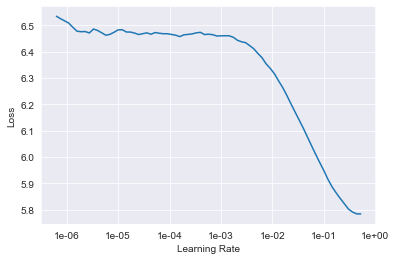

In [79]:
learn.recorder.plot(skip_end=15)

Next we fit the model for a few cycles by running 1 epoch and then unfreezing and running more epochs to fine tune.  

###    iii-  Fine-tuning

In [80]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.106545,3.806535,0.266369,00:26


In [81]:
learn.save('fit_head')
# learn.load('fit_head')

#### Gradual unfreezing
Gradual unfreezing Rather than fine-tuning all
layers at once, which risks catastrophic forgetting,
we propose to gradually unfreeze the model starting
from the last layer as this contains the least
general knowledge : We
first unfreeze the last layer and fine-tune all unfrozen
layers for one epoch. We then unfreeze the
next lower frozen layer and repeat, until we finetune
all layers until convergence at the last iteration.
This is similar to ‘chain-thaw’, except that we add a layer at a time to the
set of ‘thawed’ layers, rather than only training a
single layer at a time.

In [82]:
learn.unfreeze()

In [83]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.714701,3.668147,0.286488,00:36
1,3.585255,3.577245,0.294732,00:37
2,3.413356,3.524124,0.303780,00:36
3,3.133637,3.523530,0.304048,00:36
4,2.774845,3.594601,0.301071,00:37
5,2.395356,3.715753,0.296964,00:36
6,2.083757,3.820999,0.294940,00:35
7,1.842918,3.932663,0.292411,00:35
8,1.672739,3.991052,0.291875,00:35
9,1.614630,4.010315,0.291994,00:36


In [84]:
learn.save('fine_tuned')

In [85]:
learn.save_encoder('fine_tuned_enc')

The language model is a bit bad than I would have expected; this can be the case that the word base/ vocab of tweets donot follows same pattern as other text of english literature and dont always follow proper English spelling and grammar, making it difficult for the model to correctly predict. 

## Classifier

Next we will use the language model encoder in our classifier, which has a similar LSTM architecture but predicts the sentiment in a tweet instead of the next word. The model architecture here offers some advantages over traditional bag-of-words.

###    iv-  Transfer Learning Classifier Model

In [86]:
data_clas = (TextList.from_csv('.', 'Tweets_filtered_train.csv', cols = 'text')               
             .split_by_rand_pct(0.1, seed = seed)
             .label_from_df(cols=0)
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')
data_clas.show_batch()

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup xxunk - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup xxunk 13 / 10 . i 'm * xxup xxunk xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
xxbos @americanair xxmaj hi . i have xxup koa - xxup lax - xxup phl - xxup ord booked as a 1-way xxunk xxunk . xxmaj if i called to xxunk it to xxup koa - xxup lax - xxup phx - xxup ord would i have to pay any fees,neutral
xxbos @usairways xxmaj my xxmaj flight xxmaj booking xxmaj problems xxup xxunk just times out when i select it under xxmaj manage xxmaj my xxmaj flight xxmaj booking xxmaj problems for months now . i have emailed but no response . xxmaj help ?,negative
"xxbos @united ( 2 / 2 ) xxmaj it xxunk that if ca n't confirm xxunk at time of xxmaj flight xxmaj booking xxmaj problems , i should assume that it may never clear . xxmaj did n't used to be that way",negative
xxbos @united xxmaj missed xxup xxunk flight due to ur xxmaj cancelled xxmaj flightlation . xxmaj xxunk supervisor disgusting . xxmaj now day xxmaj late xxmaj flight . xxmaj no apology or upgrade offer to xxup lhr from xxup ord ? ? ?,negative


Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at least twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids to tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

And if we look at what a what's in our datasets, we'll see the tokenized text as a representation:

We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file).

In [87]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (11859 items)
x: TextList
xxbos @united the delay is due to customer service for 20 people ? xxmaj what about the xxup xxunk - xxup service you provided for 100 + ? # xxunk # xxunk,xxbos @united he is so excellent and so reliable :) # happycustomer,xxbos @united but again xxup united xxup xxunk xxup give 2 xxup xxunk xxup about xxup their xxup customers,xxbos @united xxmaj she is travelling from xxmaj xxunk ( xxmaj australia ) to xxmaj bogota ( xxmaj xxunk ) tomorrow,xxbos @united xxmaj hi . xxmaj my relative 's xxmaj flight xxmaj booking xxmaj problems number is xxup xxunk . xxmaj her name is xxmaj xxunk xxmaj xxunk xxmaj xxunk . xxmaj thank you
y: CategoryList
negative,positive,negative,neutral,neutral
Path: .;

Valid: LabelList (1317 items)
x: TextList
xxbos @usairways stuck on xxmaj tarmac for 30 mins at xxup phl waiting for someone to load baggage , ridiculous http : / / t.co / xxunk,xxbos @southwestair i consider myself a loyal

### v. Learning rate selection

In [88]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


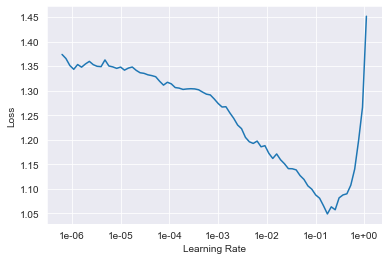

In [89]:
learn.recorder.plot()

We train by gradually unfreezing layers and then running an epoch each time, in accordance with the suggestions in the ULMFiT paper.

### vi.  Fine-Tuning

In [90]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.668024,0.518499,0.787396,01:26


In [91]:
learn.save('first')
# learn.load('first)

In [92]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.650661,0.500259,0.795748,01:28


In [93]:
learn.save('second')
# learn.load('second')

In [94]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.550781,0.457713,0.819286,01:43


In [95]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.461420,0.449646,0.818527,01:53
1,0.417430,0.475390,0.812453,02:01
2,0.366170,0.451830,0.821564,01:56


### vii. Prediction and results
Evaluate Performance on Test Set

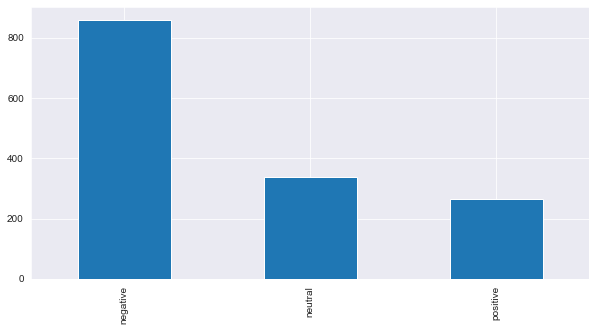

In [98]:
test_df = pd.read_csv("Tweets_filtered_test.csv", encoding="utf-8")

plt.figure(figsize=(10,5))

test_df['airline_sentiment'].value_counts().plot(kind='bar')

In [113]:
# test_df['pred_sentiment'] = test_df['text'].apply(lambda row: str(learn.predict(tf.strings.to_number(row, tf.int64)
# )[0]))
# print("Test Accuracy: ", accuracy_score(test_df['airline_sentiment'], test_df['pred_sentiment']))

In [114]:
# learn.predict(tf.strings.to_number(row, tf.int64))

In [115]:
# test_df[:20]

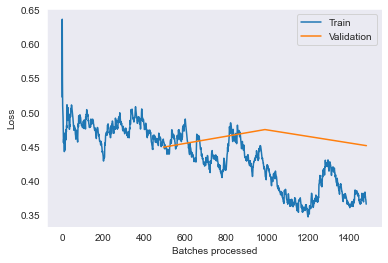

In [101]:
learn.recorder.plot_losses()

By the plot we can conclude that we had processed large number of batches that's why we see this kind of broken line

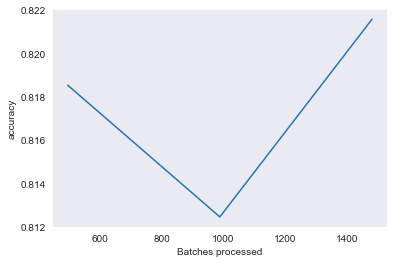

In [102]:
learn.recorder.plot_metrics()

In [104]:
learn.predict("I really hated that airline, it was nasty!")

(Category tensor(0), tensor(0), tensor([0.4642, 0.1993, 0.3365]))

In [105]:
# Prepare Interpreter
interp = ClassificationInterpretation.from_learner(learn)

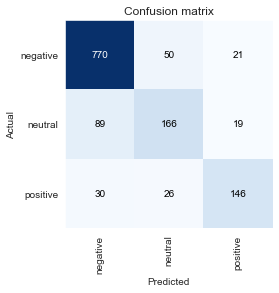

In [106]:
# Confusion Matrix
interp.plot_confusion_matrix()

In [107]:
# test_df.loc[(test_df['airline_sentiment'] == 'positive') & (test_df['pred_sentiment'] == 'negative')]

Our confusion matrix also provides decent amount of acuracy.

### Conclusion



By the conclusion, we have applied a ULMFiT on classification job for US airlines sentimental analysis where the obtained results are promising. Using transfer learning and AWD-LSTM pre-trained network we reach an accuracy of more than 82% with few learning epochs, which is pretty good compared to the literature results. However the results can be improved by using pre-train models over text-chats over social media platforms e.g. Facebook, Twitter, where nonformal language can more accurately fit this dataset compared to Wikitext-103, and for the specific question is to perform sentiment analysis happening on twitter, So if we have a pre-train model over twitter text chats would be great which in most cases contain a formal and scientific language. Besides, exploring the effect of another independent variable in the dataset could also improve the results especially the field “negativereason” . Apart from that we had done this analysis on the dataset as it is, it is more likely to have lower efficiency when we apply ULMFiT on the text-processed  data set. 


### Reference

1. J. Howard and S. Ruder, "Universal language model fine-tuning for text classification," in *ACL 2018 - 56th Annual Meeting of the Association for Computational Linguistics, Proceedings of the Conference (Long Papers)*, 2018. <br>
2. "Twitter US Airline Sentiment \| Kaggle." \[Online\]. Available: https://www.kaggle.com/crowdflower/twitter-airline-sentiment. \[Accessed: 10-Jul-2020\].
3. Ruder, J. H. (2018, May 15). Introducing state of the art text classification with universal language models. Retrieved June 22, 2020, from fast.ai NLP : http://nlp.fast.ai/classification/2018/05/15/introducing-ulmfit.html